In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [3]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.15.0


### Seeding

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

In [5]:
IMAGE_SIZE = 256
EPOCHS = 500
BATCH = 8
LR = 1e-4

image_dir = "../data/images/"
mask_dir = "../data/masks/"

## Dataset

In [6]:
def load_data(split=0.1):
    image_file_names = os.listdir(image_dir)
    images = [os.path.join(image_dir, file_name) for file_name in image_file_names if file_name.endswith('.png')]

    mask_file_names = os.listdir(mask_dir)
    masks = [os.path.join(mask_dir, file_name) for file_name in mask_file_names if file_name.endswith('.png')]

    # Mengurutkan path gambar dan masker agar sesuai satu sama lain
    images.sort()
    masks.sort()

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

### Reading the images and masks

In [7]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

### Building the tf.data pipeline for training, validation and testing dataset.

In [8]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [9]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  165
Validation data:  20
Testing data:  20


In [10]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

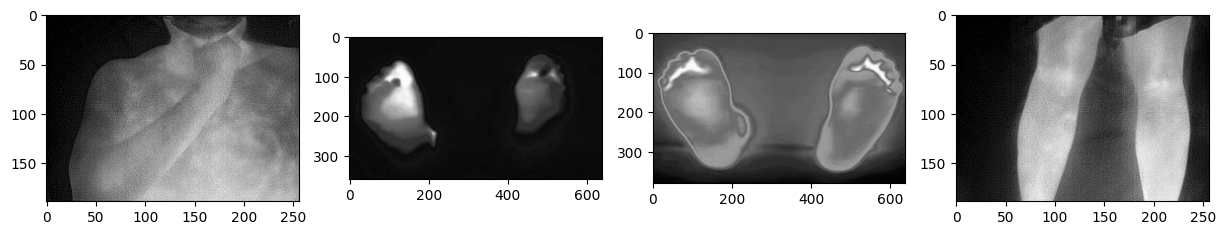

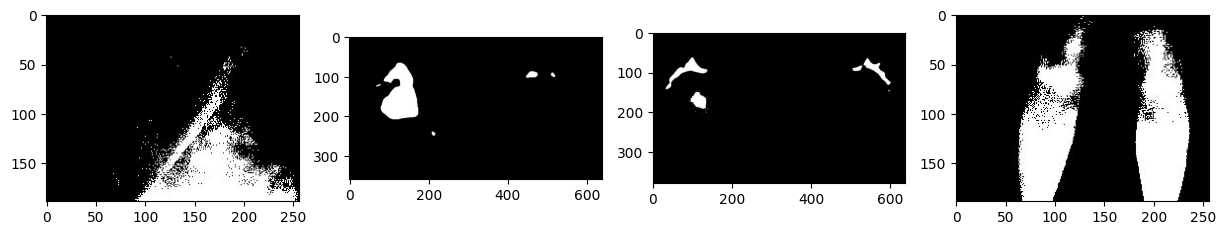

In [11]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

## Model

In [12]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [13]:
model = model()
model.summary()

2019640/2019640 [==============================] - 1s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 16)         432       ['input_image[0][0]']         
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 16)         64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [14]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Training

In [15]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [16]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [17]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [18]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/500


2024-05-12 10:49:47.581070: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50331648 exceeds 10% of free system memory.
2024-05-12 10:49:47.635698: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2024-05-12 10:49:47.645646: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73400320 exceeds 10% of free system memory.
2024-05-12 10:49:47.897099: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 82575360 exceeds 10% of free system memory.
2024-05-12 10:49:47.898039: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73400320 exceeds 10% of free system memory.


21/21 [==============================] - 32s 864ms/step - loss: 0.7608 - dice_coef: 0.2390 - recall: 0.6344 - precision: 0.3023 - val_loss: 0.8448 - val_dice_coef: 0.1542 - val_recall: 0.9949 - val_precision: 0.1543 - lr: 1.0000e-04
Epoch 2/500
21/21 [==============================] - 18s 866ms/step - loss: 0.6920 - dice_coef: 0.3072 - recall: 0.7601 - precision: 0.4353 - val_loss: 0.8182 - val_dice_coef: 0.1816 - val_recall: 0.9774 - val_precision: 0.1554 - lr: 1.0000e-04
Epoch 3/500
21/21 [==============================] - 18s 862ms/step - loss: 0.6584 - dice_coef: 0.3405 - recall: 0.7526 - precision: 0.5095 - val_loss: 0.7921 - val_dice_coef: 0.2080 - val_recall: 0.9246 - val_precision: 0.1609 - lr: 1.0000e-04
Epoch 4/500
21/21 [==============================] - 18s 853ms/step - loss: 0.6362 - dice_coef: 0.3624 - recall: 0.7425 - precision: 0.5609 - val_loss: 0.7780 - val_dice_coef: 0.2224 - val_recall: 0.7095 - val_precision: 0.3099 - lr: 1.0000e-04
Epoch 5/500
21/21 [=============

In [21]:
model.save('../models/2.0-model.h5')

/home/tinapyp/Dependencies/miniconda3/envs/dev/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model = tf.keras.models.load_model('../models/2.0-model.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

## Evaluation

In [30]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

3/3 [==============================] - 0s 114ms/step - loss: 0.8274 - dice_coef: 0.1854 - recall: 0.1162 - precision: 0.5250


[0.8273558616638184,
 0.1853783279657364,
 0.11620260775089264,
 0.5250272750854492]

## Results

In [36]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [37]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 33ms/step


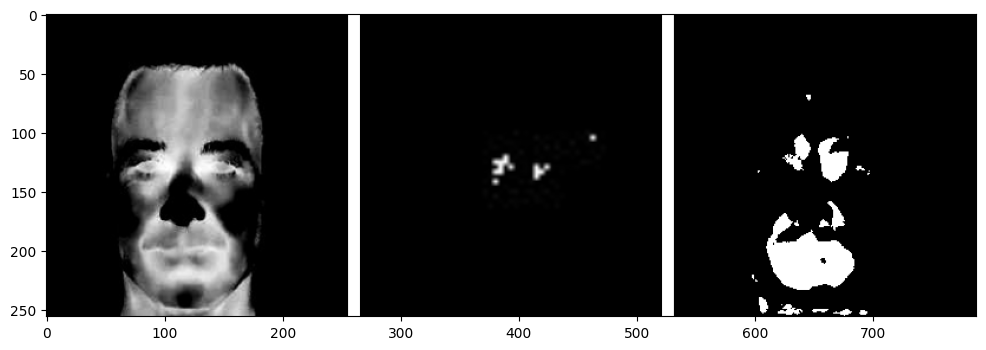

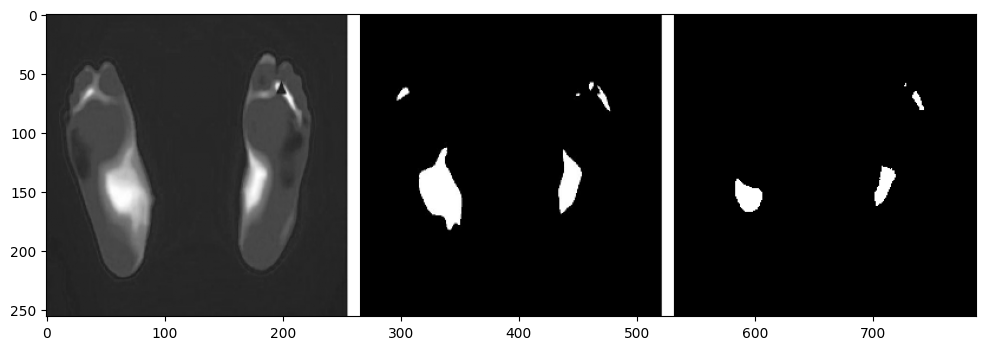

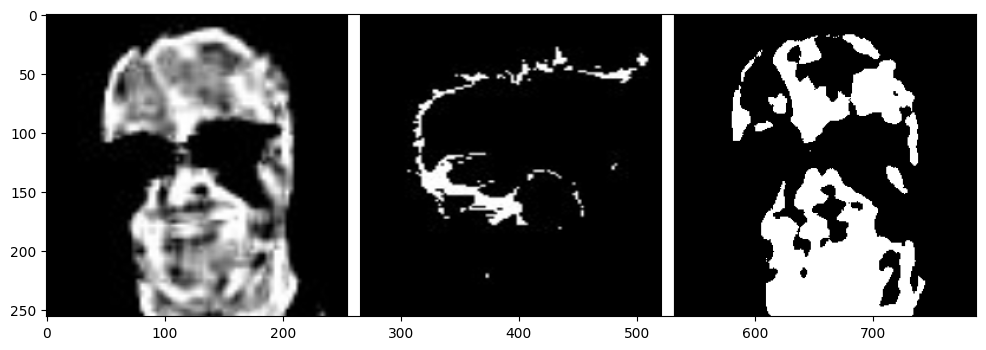

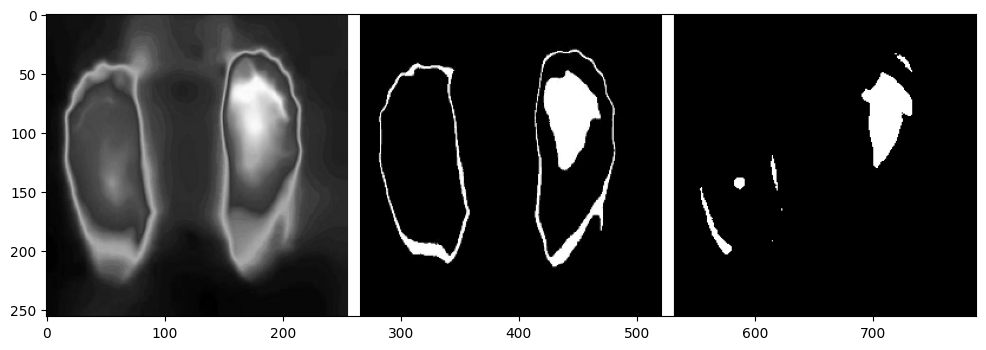

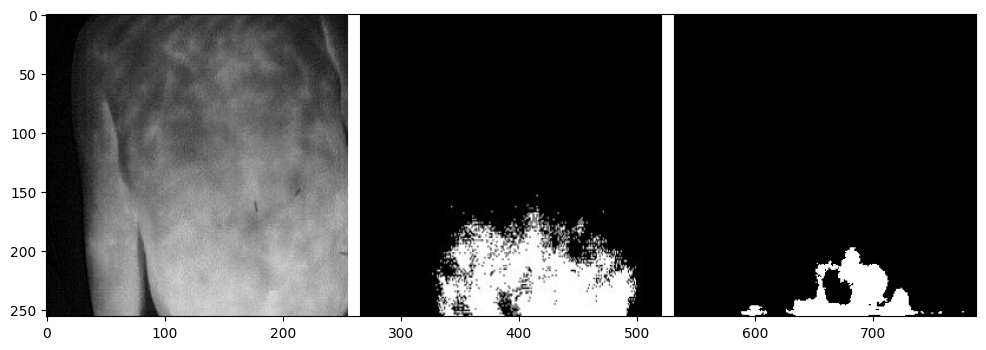

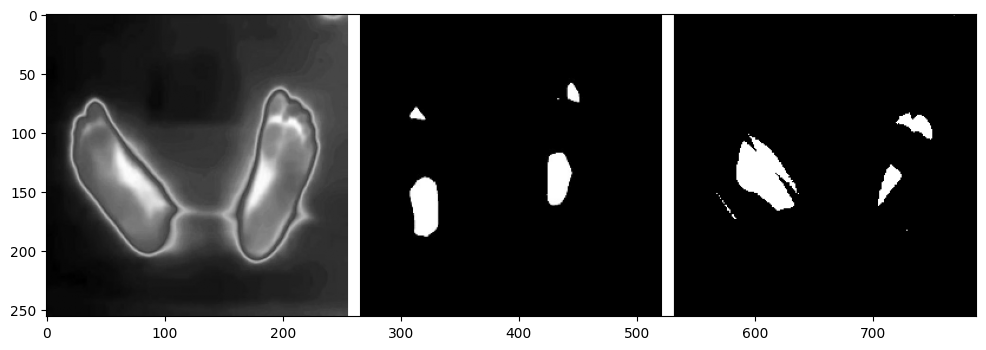

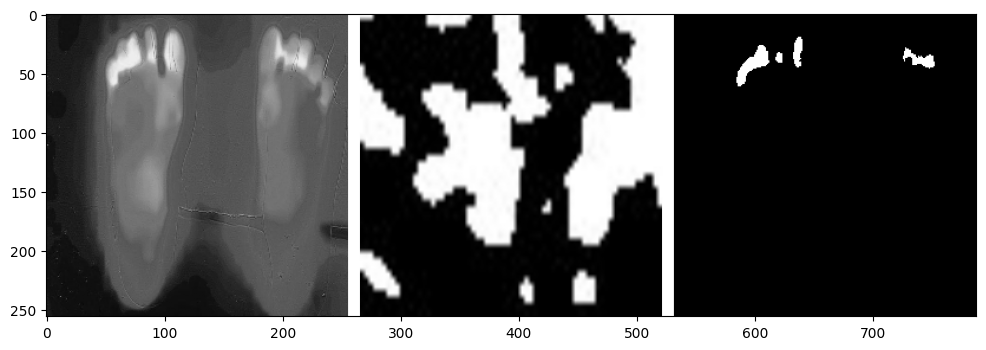

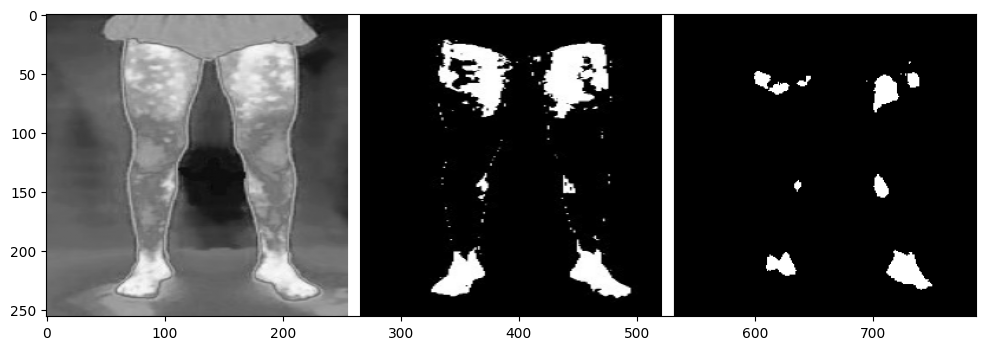

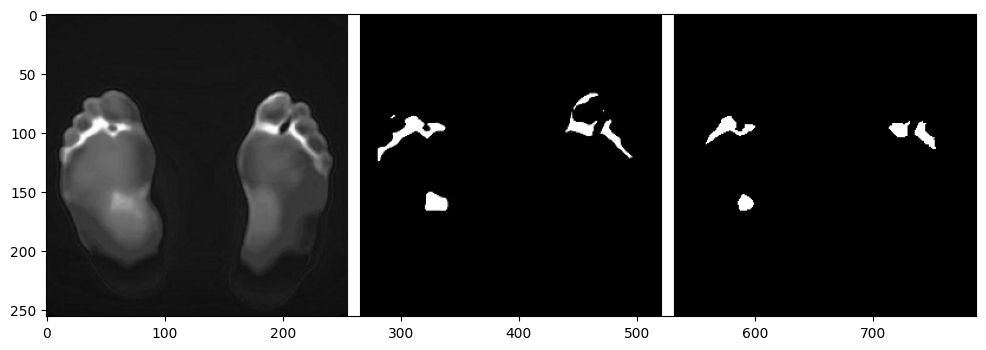

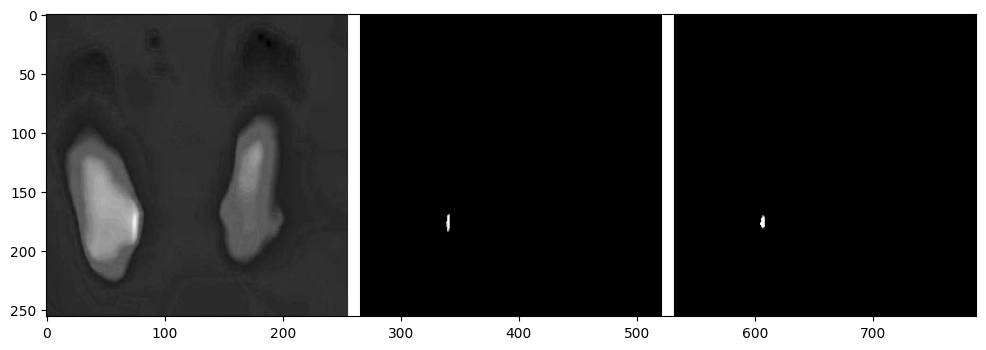

In [38]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)